In [74]:
import os
import pandas as pd
from pymongo import MongoClient
import numpy as np
import scipy.stats as stats
import seaborn as sns
pd.set_option('max_colwidth', 90)

In [2]:
def get_db_object():
    """
    """
    MONGO_URI = os.getenv("MONGO_URI")
    MONGO_DATABASE = "DJs_v7"

    client = MongoClient(MONGO_URI)
    db = client[MONGO_DATABASE]
    return db


def get_decisions_collection(db, collection_name):
    """
    """
    page_ranks_iters = []
    selected_keys = {"acordaoId": 1, "pageRank": 1, "relator": 1}
    df_collection = pd.DataFrame()
    for i in range(1, 11):
        coll_name_iter_i = collection_name + "_%d" % i
        page_ranks_cursor = (
            db[coll_name_iter_i]
            .find({}, selected_keys)
            .sort([("pageRank", -1)])
            .limit(100)
        )
        df = pd.DataFrame(page_ranks_cursor)
        df["collection_iter"] = i
        df.drop("_id", axis=1, inplace=True)
        df_collection = df_collection.append(df)

    return df_collection


def get_top_10_magistrates(df_magistrates_decs_lst):
    """
    """
    top_10_magistrates = []
    for df_magistrates_decs_pr_models in df_magistrates_decs_lst:
        relator = df_magistrates_decs_pr_models[0]["relator"].value_counts().index[0]
        top_10_magistrates.append(relator)

    return top_10_magistrates


def get_number_of_decisions_with_without_similars(db, coll_name, relatores=None):
    """
    """
    with_without_similars_sizes = []
    if relatores:
        for i, relator in enumerate(relatores):
            with_without_similars_sizes.append([i + 1, relator, db[coll_name.format(i+1)].find({}).count(), db["acordaos"].find({"relator": {"$eq": relator}}).count()])
        with_without_similars_sizes = sorted(with_without_similars_sizes, reverse=True, key=lambda x: x[3])
    else:
        with_without_similars_sizes.extend([db[coll_name].find({}).count(), db["acordaos"].find({}).count()])

    return with_without_similars_sizes


def get_intersection_decisions(df1, df2):
    """
    """
    return df1[df1["acordaoId"].isin(df2["acordaoId"])]


def get_intersection_decisions_first_iter(df1, df2):
    """
    """
    df1_iter1 = df1[df1["collection_iter"] == 1]
    df2_iter1 = df2[df2["collection_iter"] == 1]

    df_intersection_decs = get_intersection_decisions(df1_iter1, df2_iter1)
    df_intersection_decs.drop("collection_iter", axis=1, inplace=True)
    return df_intersection_decs


def get_decisions_in_at_least_8_iters_of_10(df_collection):
    """
    """
    df_collection_ids = df_collection["acordaoId"].value_counts()
    df_ids_in_8_to_10_iters = df_collection_ids[df_collection_ids >= 8].reset_index()
    df_ids_in_8_to_10_iters.drop("acordaoId", axis=1, inplace=True)
    df_ids_in_8_to_10_iters = df_ids_in_8_to_10_iters.rename(
        columns={"index": "acordaoId"}
    )
    df_ids_in_8_to_10_iters = df_collection[
        df_collection["acordaoId"].isin(df_ids_in_8_to_10_iters["acordaoId"])
    ].drop_duplicates("acordaoId")
    return df_ids_in_8_to_10_iters


def get_decisions_dataframes_tabulated(coll_name, perturbances, pr_models):
    """
    """
    coll_names = []
    for perturbance in perturbances:
        pr_models_coll_names = []
        for pr_model in pr_models:
            pr_models_coll_names.append(coll_name.format(pr_model, perturbance))
        coll_names.append(pr_models_coll_names)

    df_lst = []
    for i, perturbance in enumerate(perturbances):
        pr_models_dfs = []
        for j, pr_model in enumerate(pr_models):
            pr_models_dfs.append(get_decisions_collection(db, coll_names[i][j]))
        df_lst.append(pr_models_dfs)

    return df_lst


def get_network_robutness_tabulated(df_perturbations):
    """
    """
    df_robustness_lst = []
    for df_perturbation in df_perturbations:
        df_perturbation_lst = []
        for df_pr_model in df_perturbation:
            df_perturbation_lst.append(
                get_decisions_in_at_least_8_iters_of_10(df_pr_model)
            )
        df_robustness_lst.append(df_perturbation_lst)

    return df_robustness_lst


def get_intersection_decisions_tabulated(df_perturbations):
    """
    """
    df_intersect_lst = []
    for df_perturbation in df_perturbations:
        df_intersect_lst.append(get_intersection_decisions(*df_perturbation))

    return df_intersect_lst


def get_intersection_decisions_first_iter_tabulated(df_perturbations):
    """
    """
    df_intersect_lst = []
    for df_perturbation in df_perturbations:
        df_intersect_lst.append(get_intersection_decisions_first_iter(*df_perturbation))

    return df_intersect_lst


def get_absent_magistrates(df_perturbance_lst, top_10_magistrates):
    absent_relator_perturbances = []
    for df_perturbance in df_perturbance_lst:
        absent_relator_pr_models = []
        for pr_model in df_perturbance:
            absent_relator_pr_models.append(list(set(top_10_magistrates) - set(pr_model[pr_model["relator"].isin(top_10_magistrates)]["relator"])))
        absent_relator_perturbances.append(absent_relator_pr_models)

    return absent_relator_perturbances


def calc_qui_square_test(df):
    quisq_test, p_value, dof, _ = stats.chi2_contingency(df.values)

    print(quisq_test, p_value, dof, _)


def create_dataframe_from_list_of_list_sizes(dfs_lst, columns, index):
    """
    """
    df = pd.DataFrame(
        [[len(df) for df in dfs] for dfs in dfs_lst], columns=columns, index=index
    )
    return df


def create_dataframe_from_list_sizes(dfs, columns, index):
    """
    """
    df = pd.DataFrame([len(df) for df in dfs], columns=columns, index=index)
    return df

### Getting database experiments results and top 10 magistrates which have more decisions

103168 Collegiate decisions (acórdãos) collected from 01/02/2001 until 01/01/2020

In [5]:
db = get_db_object()

df_all_decs_lst = get_decisions_dataframes_tabulated(
    "stf_pr_{}_acordaos_{}", [10, 20, 30], [1, 2]
)
df_all_decs_no_similars_lst = get_decisions_dataframes_tabulated(
    "stf_pr_{}_acordaos_{}_no_similars", [10], [1, 2]
)
df_magistrates_decs_lst = []
top_magistrates_n = 10
for magistrate_i in range(top_magistrates_n):
    df_magistrates_decs_lst.extend(
        get_decisions_dataframes_tabulated(
            "stf_pr_{}_acordaos_{}_rel" + "_{mag}".format(mag=magistrate_i + 1),
            [10],
            [1, 2],
        )
    )

top_10_magistrates = get_top_10_magistrates(df_magistrates_decs_lst)
top_10_magistrates

['MARCO AURÉLIO',
 'CÁRMEN LÚCIA',
 'GILMAR MENDES',
 'RICARDO LEWANDOWSKI',
 'DIAS TOFFOLI',
 'LUIZ FUX',
 'ROSA WEBER',
 'ROBERTO BARROSO',
 'CELSO DE MELLO',
 'ELLEN GRACIE']

### Comparison of number of decisions considering similar decisions and nor considering them

In [ ]:
with_without_similars_all_decisions_size = get_number_of_decisions_with_without_similars(db, "stf_pr_1_acordaos_10_1")
with_without_similars_magistrates_size = get_number_of_decisions_with_without_similars(db, "stf_pr_1_acordaos_10_rel_{}_1", top_10_magistrates)

In [24]:
df_decisions_with_without_similars_sizes = pd.DataFrame([with_without_similars_all_decisions_size], columns=["with similars", "without_similars"], index=["all decisions"])
df_decisions_with_without_similars_sizes

,with similars,without_similars
all decisions,255942,103168


In [29]:
df_decisions_with_without_similars_magistrates_sizes = pd.DataFrame(sorted([x[1:] for x in with_without_similars_magistrates_size],
                                                                    key=lambda x: x[1], reverse=True),
                                                                    columns=["Magistrate", "with similars", "without_similars"]).set_index("Magistrate")
df_decisions_with_without_similars_magistrates_sizes

,with similars,without_similars
Magistrate,,
CELSO DE MELLO,23824,4622
MARCO AURÉLIO,21904,10732
CÁRMEN LÚCIA,17335,8714
GILMAR MENDES,16691,8392
RICARDO LEWANDOWSKI,13975,6905
ELLEN GRACIE,12655,4581
DIAS TOFFOLI,12238,6443
ROSA WEBER,9882,6057
ROBERTO BARROSO,9458,5539


### Getting PageRank top 100 decisions data tabulated for all decisions, for top 10 magistrates, and without similar decisions

In [30]:
df_robustness_lst = get_network_robutness_tabulated(df_all_decs_lst)
df_robustness_no_similars_lst = get_network_robutness_tabulated(
    df_all_decs_no_similars_lst
)
df_robustness_magistrates_lst = get_network_robutness_tabulated(
    df_magistrates_decs_lst
)

### Getting intersections of top 100 decisions measures between both pageRank models for all decisions, for top 10 magistrates, and without similar decisions

In [31]:
df_robustness_intersect_all_decs_lst = get_intersection_decisions_tabulated(
    df_robustness_lst
)
df_robustness_intersect_no_similars_lst = get_intersection_decisions_tabulated(
    df_robustness_no_similars_lst
)
df_robustness_intersect_magistrates_lst = get_intersection_decisions_tabulated(
    df_robustness_magistrates_lst
)
df_robustness_intersect_between_with_and_without_sim_pr1_lst = get_intersection_decisions_tabulated(
    [[df_robustness_lst[0][0], df_robustness_no_similars_lst[0][0]]]
)
df_robustness_intersect_between_with_and_without_sim_pr2_lst = get_intersection_decisions_tabulated(
    [[df_robustness_lst[0][1], df_robustness_no_similars_lst[0][1]]]
)

### Building robustness tables for all PageRank top 100 measures (all decisions, top 10 magistrates, and without similar decisions)

In [33]:
df_all_decs_robustness_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_lst, [1, 2], [10, 20, 30]
)
df_no_similars_robustness_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_no_similars_lst, [1, 2], [10]
)
df_magistrates_robustness_table = create_dataframe_from_list_of_list_sizes(
    df_robustness_magistrates_lst, [1, 2], top_10_magistrates
)

### Comparison between PR1 and P2 Pagerank models results for all decisions WITH similars

In [50]:
df_all_decs_robustness_table.columns = ["PR1", "PR2"]
df_all_decs_robustness_table.index.name = "Perturbance level (%)"
df_all_decs_robustness_table

,PR1,PR2
Perturbance level (%),,
10,76,93
20,31,25
30,19,59


### Comparison between PR1 and P2 Pagerank models results for all decisions WITHOUT similars

In [53]:
df_no_similars_robustness_table.columns = ["PR1", "PR2"]
df_no_similars_robustness_table.index.name = "Perturbance level (%)"
df_no_similars_robustness_table

,PR1,PR2
Perturbance level (%),,
10,85,57


### Comparison between PR1 and P2 Pagerank models results for top 10 magistrates (10% disturbance level) decisions with similar decisions

In [46]:
df_magistrates_robustness_table.columns = ["PR1", "PR2"]
df_magistrates_robustness_table.index.name = "Magistrate"
df_magistrates_robustness_table

,PR1,PR2
Magistrate,,
MARCO AURÉLIO,82,82
CÁRMEN LÚCIA,78,72
GILMAR MENDES,80,99
RICARDO LEWANDOWSKI,74,80
DIAS TOFFOLI,83,91
LUIZ FUX,78,83
ROSA WEBER,85,81
ROBERTO BARROSO,87,88
CELSO DE MELLO,93,82


### Building robustness table for intersection of decisions between PageRank top 100 measure for decisions with similar vs decisions without similar decisions

In [34]:
pr_models = [1, 2]
df_robustness_decs_with_similars_vs_without_similars_lst = []
for i, pr_model in enumerate(pr_models):
    df_robustness_decs_with_similars_vs_without_similars_lst.append(
        get_intersection_decisions(
            df_robustness_lst[0][i], df_robustness_no_similars_lst[0][i]
        )
    )

df_decs_with_similars_vs_without_similars_robustness_table = create_dataframe_from_list_of_list_sizes(
    [df_robustness_decs_with_similars_vs_without_similars_lst], [1, 2], [10]
)

In [79]:
df_decs_with_similars_vs_without_similars_robustness_table.columns = ["PR1", "PR2"]
df_decs_with_similars_vs_without_similars_robustness_table.index.name = "Perturbance level (%)"
df_decs_with_similars_vs_without_similars_robustness_table

,PR1,PR2
Perturbance level (%),,
10,29,2


### Building robustness tables for intersections of top 100 decisions measures between both pageRank models for all decisions, for top 10 magistrates, and without similar decisions

In [35]:
df_all_decs_intersection_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_all_decs_lst, ["Intersect"], [10, 20, 30]
)
df_no_similars_intersect_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_no_similars_lst, ["Intersect"], [10]
)
df_magistrates_intersection_table = create_dataframe_from_list_sizes(
    df_robustness_intersect_magistrates_lst,
    ["Intersect"],
    top_10_magistrates,
)

### Intersection of decisions between PageRank 1 and 2 models results for decisions WITH similars

In [52]:
df_all_decs_intersection_table.index.name = "Perturbance level (%)"
df_all_decs_intersection_table

,Intersect
Perturbance level (%),
10,18
20,8
30,5


### Intersection of decisions between PageRank 1 and 2 models results for decisions WITHOUT similars

In [54]:
df_no_similars_intersect_table.index.name = "Perturbance level (%)"
df_no_similars_intersect_table

,Intersect
Perturbance level (%),
10,10


### Chi-square test to compare similarity between PageRank models results 1 and 2

### Comparison between PageRank models results for all decisions with similars

In [55]:
calc_qui_square_test(df_all_decs_robustness_table)

14.697980364712992 0.0006432415892048291 2 [[70.27722772 98.72277228]
 [23.28712871 32.71287129]
 [32.43564356 45.56435644]]


**Chi squared statistic: 14.69**  
**p-value: 0.0006**

### Comparison between PageRank models results for all magistrates

In [56]:
calc_qui_square_test(df_magistrates_robustness_table)

3.6775405787273248 0.9313266934796394 9 [[81.21342926 82.78657074]
 [74.28057554 75.71942446]
 [88.64148681 90.35851319]
 [76.26139089 77.73860911]
 [86.16546763 87.83453237]
 [79.72781775 81.27218225]
 [82.20383693 83.79616307]
 [86.66067146 88.33932854]
 [86.66067146 88.33932854]
 [84.18465228 85.81534772]]


**Chi squared statistic: 3.67**  
**p-value: 0.9313**

### Getting intersection of decisions between both PageRank models for iteration 1 for all measures (all decisions, top 10 magistrates, and without similar decisions)

In [36]:
df_intersec_with_sim_dec_lst = get_intersection_decisions_first_iter_tabulated(
    df_all_decs_lst
)
df_intersec_without_sim_dec_lst = get_intersection_decisions_first_iter_tabulated(
    df_all_decs_no_similars_lst
)
df_intersec_magistrates_lst = get_intersection_decisions_first_iter_tabulated(
    df_magistrates_decs_lst
)

/home/jackson/.local/share/virtualenvs/analise-juridica-SICVn6Yg/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Getting intersection of decisions between both PageRank models for iteration 1 for decisions with similar vs decisions without similar decisions

In [37]:
df_intersec_between_with_and_without_sim_pr1 = get_intersection_decisions_first_iter_tabulated(
    [[df_all_decs_lst[0][0], df_all_decs_no_similars_lst[0][0]]]
)
df_intersec_between_with_and_without_sim_pr2 = get_intersection_decisions_first_iter_tabulated(
    [[df_all_decs_lst[0][1], df_all_decs_no_similars_lst[0][1]]]
)

### Building robustness tables for intersections of top 100 decisions measures between both pageRank models for all decisions, for top 10 magistrates, and without similar decisions IN THE FIRST ITERATION

In [38]:
df_intersec_with_sim_dec_table = create_dataframe_from_list_sizes(
    df_intersec_with_sim_dec_lst, ["Intersect"], [10, 20, 30]
)
df_intersec_without_sim_dec_table = create_dataframe_from_list_sizes(
    df_intersec_without_sim_dec_lst, ["Intersect"], [10]
)
df_intersec_magistrates_table = create_dataframe_from_list_sizes(
    df_intersec_magistrates_lst, ["Intersect"], top_10_magistrates
)

### Comparison between PR1 and P2 Pagerank models results for all decisions WITH similars IN THE FIRST ITERATION

In [58]:
df_intersec_with_sim_dec_table.index.name = "Perturbance level (%)"
df_intersec_with_sim_dec_table

,Intersect
Perturbance level (%),
10,21
20,21
30,21


### Comparison between PR1 and P2 Pagerank models results for all decisions WITHOUT similars IN THE FIRST ITERATION

In [60]:
df_intersec_without_sim_dec_table.index.name = "Perturbance level (%)"
df_intersec_without_sim_dec_table

,Intersect
Perturbance level (%),
10,21


### Comparison between PR1 and P2 Pagerank models results for top 10 magistrates (10% disturbance level) WITH similars IN THE FIRST ITERATION

In [62]:
df_intersec_magistrates_table.index.name = "Magistrates"
df_intersec_magistrates_table

,Intersect
Magistrates,
MARCO AURÉLIO,80
CÁRMEN LÚCIA,81
GILMAR MENDES,80
RICARDO LEWANDOWSKI,79
DIAS TOFFOLI,82
LUIZ FUX,77
ROSA WEBER,90
ROBERTO BARROSO,86
CELSO DE MELLO,70


### Building robustness table for intersection of decisions between PageRank top 100 measure for decisions with similar vs decisions without similar decisions IN THE FIRST ITERATION

In [39]:
df_intersec_between_with_and_without_sim_pr1_table = create_dataframe_from_list_sizes(
    df_intersec_between_with_and_without_sim_pr1, ["Intersect"], [1]
)
df_intersec_between_with_and_without_sim_pr2_table = create_dataframe_from_list_sizes(
    df_intersec_between_with_and_without_sim_pr2, ["Intersect"], [2]
)

In [82]:
df_intersec_between_with_and_without_sim_pr1_table, df_intersec_between_with_and_without_sim_pr2_table

(   Intersect
 1         47,
    Intersect
 2         13)

first iteration  
      PR1     |     PR2  
      47      |     13  
      
      
all iterations  
      PR1     |      PR2
      22      |       2

### Getting magistrates absent from top 100 ranking measures considering similar decisions and not considering them

In [40]:
absent_magistrates_lst = get_absent_magistrates(df_robustness_lst, top_10_magistrates)
absent_magistrates_no_similars_lst = get_absent_magistrates(df_robustness_no_similars_lst, top_10_magistrates)

### Absent magistrates from top 100 decisions in each PageRank experiment for decisions WITH similars

In [73]:
df_absent_magistrates_with_similars = pd.DataFrame(absent_magistrates_lst,
                                                   columns=["PR1", "PR2"],
                                                   index=[10, 20, 30])
df_absent_magistrates_with_similars.index.name = "Perturbance level (%)"
df_absent_magistrates_with_similars

,PR1,PR2
Perturbance level (%),,
10,"[DIAS TOFFOLI, LUIZ FUX, ROSA WEBER]",[ROBERTO BARROSO]
20,"[CÁRMEN LÚCIA, DIAS TOFFOLI, ROSA WEBER, LUIZ FUX, ROBERTO BARROSO]","[DIAS TOFFOLI, LUIZ FUX, ROBERTO BARROSO, RICARDO LEWANDOWSKI]"
30,"[CÁRMEN LÚCIA, DIAS TOFFOLI, ROSA WEBER, LUIZ FUX, CELSO DE MELLO, ROBERTO BARROSO]","[CELSO DE MELLO, ROBERTO BARROSO]"


### Absent magistrates from top 100 decisions in each PageRank experiment for decisions WITHOUT similars

In [76]:
df_absent_magistrates_without_similars = pd.DataFrame(absent_magistrates_no_similars_lst,
                                                   columns=["PR1", "PR2"],
                                                   index=[10])
df_absent_magistrates_without_similars.index.name = "Perturbance level (%)"
df_absent_magistrates_without_similars

,PR1,PR2
Perturbance level (%),,
10,"[RICARDO LEWANDOWSKI, LUIZ FUX, ROSA WEBER]","[LUIZ FUX, ROBERTO BARROSO, ROSA WEBER]"


In [41]:
def plot_robustness_graph(df_perturbances, df_intersect):
    """
    """
    df = df_perturbances.join(df_intersect)
    df["Attack level"] = ["10%", "20%", "30%"]
    df = df.rename(columns={1: "$PR_1$", 2: "$PR_2$", "Intersect": "Intersection of $PR_1$ and $PR_2$"})
    df = df.set_index("Attack level")

    sns.set()
    ax = sns.lineplot(data=df, linewidth=2.5)
    ax.set(xlabel="Attack level", ylabel="PageRankTop100")
    fig = ax.get_figure()
    fig.savefig("PageRankTop100_disturbance.png")

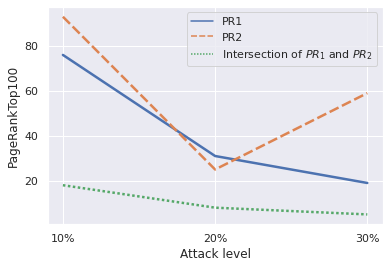

In [77]:
plot_robustness_graph(df_all_decs_robustness_table, df_all_decs_intersection_table)

In [83]:
# Entender que valores são estes (provavelmente primeira lista é p1 e segunda é p2)
calc_qui_square_test(pd.DataFrame(np.array([[47, 22], [13, 2]])))

1.2681159420289854 0.26012042564948784 1 [[49.28571429 19.71428571]
 [10.71428571  4.28571429]]


**Chi squared statistic: 1.26**  
**p-value: 0.2601**

In [88]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pymongo import MongoClient
from GraphMaker import GraphMaker


def preprocess_query(query_raw):
    query = {}
    if query_raw:
        queryPairs = query_raw.split(",")
        if not queryPairs:
            queryPairs = query_raw
        for pair in queryPairs:
            pairSplit = pair.split(":")
            field = pairSplit[0].strip()
            value = pairSplit[1].strip()
            query[field] = value
    return query


def get_decisions_ids(collections, query):
    MONGO_URI = os.getenv("MONGO_URI")
    MONGO_DATABASE = os.getenv("MONGO_DATABASE")
    client = MongoClient(MONGO_URI)
    db = client[MONGO_DATABASE]

    decisions_ids = []
    colls = []
    if collections == "acordaos":
        colls.append(db["acordaos"])
    elif collections == "decisoes_monocraticas":
        colls.append(db["decisoes_monocraticas"])
    elif collections == "decisoes":
        colls.append(db["acordaos"])
        colls.append(db["decisoes_monocraticas"])

    for coll in colls:
        docs = coll.find(query, no_cursor_timeout=True)
        for doc in docs:
            decisions_ids.append(doc["acordaoId"])
            # decisions_ids.append([doc["acordaoId"], doc["observacao"], doc["similaresTexto"]])

    return decisions_ids, colls


def run_page_rank_iteration(query, collections_name):
    decisions_ids, collections = get_decisions_ids(
         collections_name, query
    )

    MONGO_URI = os.getenv("MONGO_URI")
    MONGO_DATABASE = os.getenv("MONGO_DATABASE")
    collection_out_iter_name = "_fake_coll"
    graphMaker = GraphMaker(
        MONGO_URI,
        MONGO_DATABASE,
        collections,
        collection_out_iter_name,
    )

    removed_decisions = []
    compute_similars = "S"
    [acordaos, quotes, quotedBy, similars] = graphMaker.buildDicts(
        query, removed_decisions, compute_similars
    )
    [quotes, quotedBy] = graphMaker.removeInvalidAcordaosFromDicts(
        acordaos, quotes, quotedBy
    )
    # faz grafo ficar sem direção
    new_quotes = {}
    for k, vals in quotes.items():
        if k not in new_quotes:
            new_quotes[k] = set(vals)
        elif k not in new_quotes[v]:
            new_quotes[k].update(vals)
        for v in vals:
            if v not in new_quotes:
                new_quotes[v] = set([k])
            elif k not in new_quotes[v]:
                new_quotes[v].update([k])

    return new_quotes


def create_papers_graphs(new_quotes):
    nodes_degrees = [len(v) for k, v in new_quotes.items()]
    df = pd.DataFrame(nodes_degrees, columns=["count"])
    df_counts = df["count"].value_counts().reset_index()
    df_counts = df_counts.rename(columns={"index": "K"})
    df_counts = df_counts.sort_values(by=['K'])
    N = df_counts["count"].sum()
    df_counts["P(K)"] = df_counts["count"].apply(lambda x: x/N)
    df_counts["log P(K)"] = df_counts["P(K)"].apply(lambda x: np.log(x))
    df_counts["log K"] = df_counts["K"].apply(lambda x: np.log(x))
    df_counts["log P(K) / log K"] = - df_counts["log P(K)"] / df_counts["log K"]

    ax = sns.lmplot(data=df_counts[df_counts["K"] > 0], y="log P(K)", x="log K")
    gamma = df_counts[df_counts["log K"] > 0]["log P(K) / log K"].mean()
    red_patch = mpatches.Patch(label=r"$\gamma$: {:.2f}".format(gamma))
    plt.legend(handles=[red_patch])
    plt.show()
    ax.savefig("gamma_value_log.png")

    plt.clf()
    plt.cla()
    plt.close()

    ax = sns.distplot(df_counts["K"], kde=False, norm_hist=True, bins=100)
    ax.set(yscale="log")
    ax.set(ylim=(0.0001, 0.01))
    red_patch = mpatches.Patch(label=r"Mean: {:.2f}".format(np.mean(df[df["count"] > 0]["count"])))
    plt.legend(handles=[red_patch])
    plt.show()
    ax.figure.savefig("graph_node_degrees_hist.png")


query_raw = ""
query = preprocess_query(query_raw)
new_quotes = run_page_rank_iteration(query, "acordaos")
create_papers_graphs(new_quotes)

ModuleNotFoundError: No module named 'Acordao'